In [1]:
import numpy as np
import pandas as pd
import os
from random import shuffle
import cv2
import time
import seaborn as sns
import matplotlib.pyplot as plt
import glob as gb
%matplotlib inline


In [2]:
import keras
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D,GlobalMaxPooling2D,AveragePooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout,Concatenate
from tensorflow.keras.layers import Dense,Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img,img_to_array,ImageDataGenerator
from keras.optimizers import Adam
from keras.models import Model
from keras.applications.resnet50 import ResNet50
from keras.applications.mobilenet import MobileNet
from keras.regularizers import l2
from keras.losses import categorical_crossentropy
from imutils import paths
from sklearn.model_selection import train_test_split

In [3]:
WIDTH=224
HEIGHT=224

In [4]:
train_image = "dataset/train"
test_image = "dataset/test"


print(train_image)
print(test_image)

dataset/train
dataset/test


In [5]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   zoom_range = 0.2,
                                   rotation_range=15,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)


In [6]:
from keras import backend as K
def precision_threshold(threshold = 0.5):
    def precision(y_true, y_pred):
        threshold_value = threshold
        y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), threshold_value), K.floatx())
        true_positives = K.round(K.sum(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(y_pred)
        precision_ratio = true_positives / (predicted_positives + K.epsilon())
        return precision_ratio
    return precision
def recall_threshold(threshold = 0.5):
    def recall(y_true, y_pred):
        threshold_value = threshold
        y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), threshold_value), K.floatx())
        true_positives = K.round(K.sum(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.clip(y_true, 0, 1))
        recall_ratio = true_positives / (possible_positives + K.epsilon())
        return recall_ratio
    return recall
def fbeta_score_threshold(beta = 1, threshold = 0.5):
    def fbeta_score(y_true, y_pred):
        threshold_value = threshold
        beta_value = beta
        p = precision_threshold(threshold_value)(y_true, y_pred)
        r = recall_threshold(threshold_value)(y_true, y_pred)
        bb = beta_value ** 2
        fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
        return fbeta_score
    return fbeta_score

In [7]:
#hybrid model
IMAGE_SIZE=(224,224,3)

#Resnet50 model
resnet50 = ResNet50(input_shape=IMAGE_SIZE, weights='imagenet', include_top=False)
for layer in resnet50.layers:
    layer._name = layer._name + str('_resnet50')
    layer.trainable = False
    
#mobilenet model
mobilenet = MobileNet(input_shape=IMAGE_SIZE, weights='imagenet', include_top=False)
for layer in mobilenet.layers:
    layer._name = layer._name + str('_mobilenet')
    layer.trainable = False

inp = Input(IMAGE_SIZE)
    
resnet50_x = Flatten()(resnet50(inp))
mobilenet_x   = Flatten()(mobilenet(inp))

x = Concatenate()([resnet50_x, mobilenet_x])
x = Dense(512, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(256, activation="relu")(x)
out = Dense(3, activation='softmax')(x)

model = Model(inputs = inp, outputs = out)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
resnet50 (Functional)           (None, 7, 7, 2048)   23587712    input_3[0][0]                    
__________________________________________________________________________________________________
mobilenet_1.00_224 (Functional) (None, 7, 7, 1024)   3228864     input_3[0][0]                    
__________________________________________________________________________________________________
flatten (Flatten)               (None, 100352)       0           resnet50[0][0]                   
_______________________________________________________________________________________

In [8]:
opt=Adam(learning_rate=0.001)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=[precision_threshold(threshold = 0.5), 
                       recall_threshold(threshold = 0.5), 
                       fbeta_score_threshold(beta=0.5, threshold = 0.5),
                      'accuracy','AUC',])
    
train_generator = train_datagen.flow_from_directory(train_image,
                                                 target_size = (224,224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical',
                                                 shuffle=True)

test_generator = test_datagen.flow_from_directory(test_image,
                                            target_size = (224,224),
                                            batch_size = 64,
                                            class_mode = 'categorical',
                                            shuffle = False)

start=time.time()
history = model.fit_generator(train_generator,
                              validation_data=test_generator,
                              epochs=30) 
print("training time: %.2f minutes"%((time.time()-start)/60))

Found 5144 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
81/81 [==============================] - 469s 6s/step - loss: 4.6810 - precision: 0.8508 - recall: 0.8499 - fbeta_score: 0.8505 - accuracy: 0.8501 - auc: 0.9160 - val_loss: 0.6545 - val_precision: 0.9301 - val_recall: 0.9301 - val_fbeta_score: 0.9301 - val_accuracy: 0.9270 - val_auc: 0.9705
Epoch 2/30
81/81 [==============================] - 483s 6s/step - loss: 0.4806 - precision: 0.9254 - recall: 0.9252 - fbeta_score: 0.9254 - accuracy: 0.9252 - auc: 0.9712 - val_loss: 0.2036 - val_precision: 0.9546 - val_recall: 0.9546 - val_fbeta_score: 0.9546 - val_accuracy: 0.9526 - val_auc: 0.9853
Epoch 3/30
81/81 [==============================] - 471s 6s/step - loss: 0.2554 - precision: 0.9407 - recall: 0.9407 - fbeta_score: 0.9407 - accuracy: 0.9415 - auc: 0.9846 - val_loss: 0.2136 - val_precision: 0.9382 - val_recall: 0.938

Epoch 27/30
81/81 [==============================] - 457s 6s/step - loss: 0.1058 - precision: 0.9634 - recall: 0.9599 - fbeta_score: 0.9627 - accuracy: 0.9623 - auc: 0.9965 - val_loss: 0.1680 - val_precision: 0.9486 - val_recall: 0.9472 - val_fbeta_score: 0.9483 - val_accuracy: 0.9449 - val_auc: 0.9925
Epoch 28/30
81/81 [==============================] - 445s 5s/step - loss: 0.1308 - precision: 0.9558 - recall: 0.9542 - fbeta_score: 0.9555 - accuracy: 0.9547 - auc: 0.9947 - val_loss: 0.1453 - val_precision: 0.9553 - val_recall: 0.9539 - val_fbeta_score: 0.9550 - val_accuracy: 0.9519 - val_auc: 0.9935
Epoch 29/30
81/81 [==============================] - 445s 5s/step - loss: 0.1034 - precision: 0.9640 - recall: 0.9614 - fbeta_score: 0.9635 - accuracy: 0.9623 - auc: 0.9959 - val_loss: 0.1770 - val_precision: 0.9367 - val_recall: 0.9345 - val_fbeta_score: 0.9362 - val_accuracy: 0.9379 - val_auc: 0.9895
Epoch 30/30
81/81 [==============================] - 444s 5s/step - loss: 0.0914 - preci

In [9]:
model.save_weights('Hybrid_resnet50+mobilenet.h5')

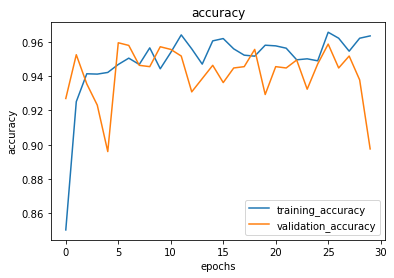

In [10]:
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.plot(history.history['accuracy'],label='training_accuracy')
plt.plot(history.history['val_accuracy'],label='validation_accuracy')
plt.legend()
plt.savefig('accuracy_Hybrid_resnet50+mobilenet.png')

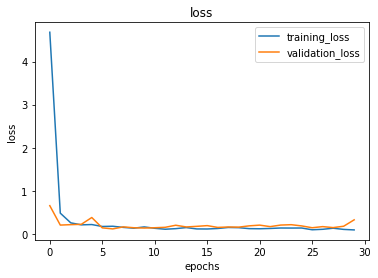

In [11]:
plt.title('loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(history.history['loss'],label='training_loss')
plt.plot(history.history['val_loss'],label='validation_loss')
plt.legend()
plt.savefig('loss_Hybrid_resnet50+mobilenet.png')

In [12]:
test_generator.reset() #Necessary to force it to start from beginning
Y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=-1)

Instructions for updating:
Please use Model.predict, which supports generators.


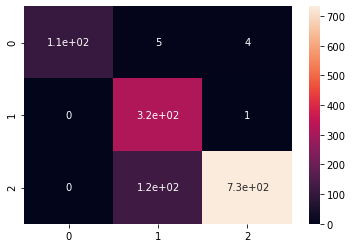

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(test_generator.classes,y_pred)
sns.heatmap(cm, annot=True)
plt.savefig('confusion_matrix_Hybrid_resnet50+mobilenet.png')

In [14]:
tp=cm[0,0]
fp=cm[0,:].sum()- tp
fn=cm[:,0].sum()- tp
tn=cm.sum().sum()-tp-fp-fn
precision=tp/(tp+fp)
recall=tp/(tp+fn)
f1_score=(2*precision*recall)/(precision+recall)
acc=cm.trace()/cm.sum()
print("Test Accuracy :", acc)
print("Test Precision :", precision)
print("Test Recall :", recall)
print("Test F1_Score :", f1_score)

Test Accuracy : 0.8975155279503105
Test Precision : 0.9224137931034483
Test Recall : 1.0
Test F1_Score : 0.9596412556053812


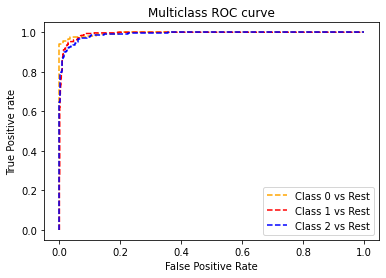

In [15]:
from sklearn.metrics import roc_curve, auc

fpr = {}
tpr = {}
thresh ={}

n_class = 3

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(test_generator.classes, Y_pred[:,i], pos_label=i)
       
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='red', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);    


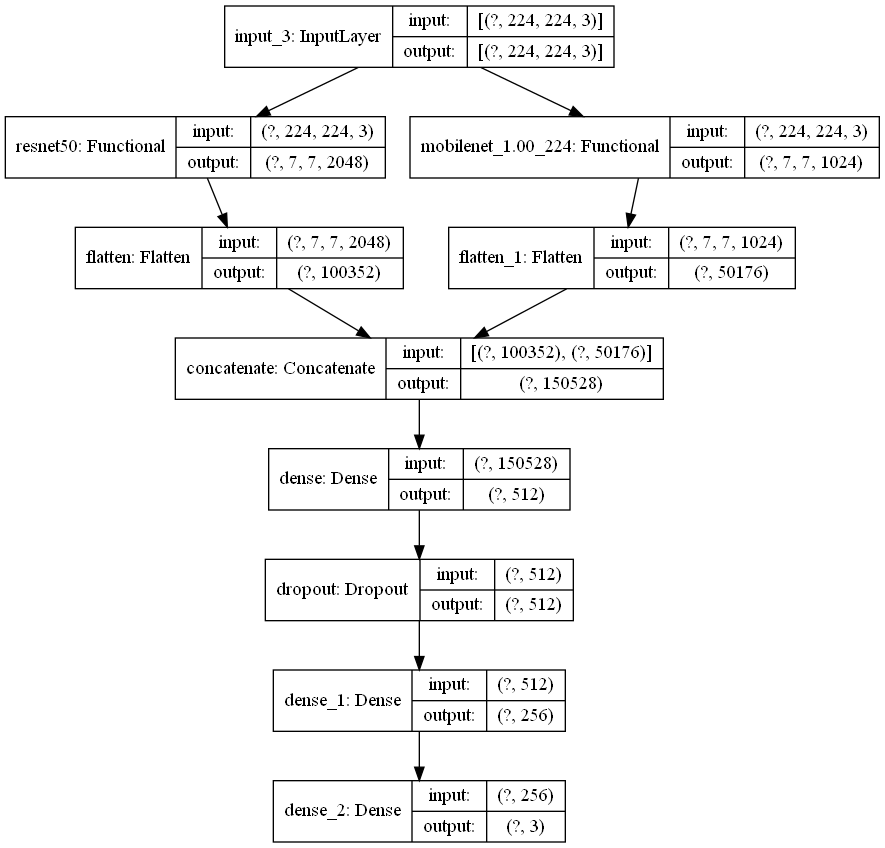

In [16]:
from keras.utils import plot_model
plot_model(model,to_file='Hybrid_resnet50+mobilenet_model.png',show_shapes=True)